<a href="https://colab.research.google.com/github/EnqiangYuan-hub/EthicsinAI_RefugeeDetermination/blob/main/StudentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias in AI Decision-Making: A Refugee Status Determination Case Study

This workbook explores how automated systems can encode and amplify bias in high-stakes humanitarian decisions. You will examine a synthetic dataset modeled on real Refugee Status Determination (RSD) processes, uncover patterns of bias in an AI decision pipeline, and write your own bias audit.

The dataset and scenario are inspired by UNHCR's use of algorithmic tools in refugee processing, and by academic research on fairness in automated legal decision-making.

**Upload `RefugeeProfile.csv` to your Colab session before starting.**

## 0. Setup

Run both cells below first. You don't need to modify anything here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sns.set_theme(style="whitegrid", palette="muted")
np.random.seed(42)
print("Libraries loaded!")

Libraries loaded!


In [3]:
def viewDecisionDistribution(data, decision_col='final_decision'):
    counts = data[decision_col].value_counts()
    plt.figure()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%',
            startangle=90, colors=['#66c2a5', '#fc8d62'])
    plt.title(f'Distribution of: {decision_col}')
    plt.tight_layout()
    plt.show()

def viewApprovalRateBy(data, groupby_col, decision_col='final_decision'):
    rate = (data.groupby(groupby_col)[decision_col]
            .apply(lambda x: (x == 'approve').mean())
            .sort_values().reset_index())
    rate.columns = [groupby_col, 'approval_rate']
    plt.figure(figsize=(8, 4))
    plt.barh(rate[groupby_col], rate['approval_rate'],
             color='#66c2a5', edgecolor='white')
    plt.axvline(rate['approval_rate'].mean(), color='#fc8d62',
                linestyle='--', linewidth=1.5, label='Overall average')
    plt.xlabel('Approval Rate')
    plt.title(f'Approval Rate by {groupby_col}')
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

def viewScoreDistribution(data, score_col, hue_col=None):
    plt.figure(figsize=(8, 4))
    if hue_col:
        for val in data[hue_col].unique():
            sns.kdeplot(data[data[hue_col] == val][score_col],
                        label=str(val), fill=True, alpha=0.4)
        plt.legend(title=hue_col)
    else:
        sns.histplot(data[score_col], bins=30, kde=True, color='#66c2a5')
    plt.xlabel(score_col)
    plt.ylabel('Density')
    plt.title(f'{score_col}' + (f' by {hue_col}' if hue_col else ''))
    plt.tight_layout()
    plt.show()

def viewScoreByDecision(data, score_col, decision_col='final_decision'):
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, x=decision_col, y=score_col,
                palette={'approve': '#66c2a5', 'deny': '#fc8d62'})
    plt.title(f'{score_col} by {decision_col}')
    plt.tight_layout()
    plt.show()

def viewCategoricalBreakdown(data, category_col, hue_col='final_decision'):
    plt.figure(figsize=(9, 4))
    palette = {'approve': '#66c2a5', 'deny': '#fc8d62',
               'Male': '#66c2a5', 'Female': '#fc8d62', 'Non-binary': '#8da0cb',
               True: '#fc8d62', False: '#66c2a5'}
    sns.countplot(data=data, x=category_col, hue=hue_col, palette=palette,
                  order=data[category_col].value_counts().index)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{category_col} by {hue_col}')
    plt.tight_layout()
    plt.show()

def plotFeatureImportance(model, X_train):
    importances = pd.Series(model.feature_importances_,
                            index=X_train.columns).sort_values()
    plt.figure(figsize=(7, 5))
    importances.plot(kind='barh', color='#66c2a5', edgecolor='white')
    plt.xlabel('Importance')
    plt.title('Feature Importance — Random Forest')
    plt.tight_layout()
    plt.show()

print("Helper functions loaded!")

Helper functions loaded!


## 1. Import & Preview the Data

Each row is one asylum applicant. The dataset has 500 applicants and 21 variables covering demographics, legal claim, AI-generated scores, and decision outcomes. Refer to the **Codebook** on Canvas if you're unsure what a variable means.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/RefugeeProfile.csv')
print(f"Shape: {df.shape}")
df.head(10)

Mounted at /content/drive
Shape: (500, 21)


,id,country_of_origin,gender,age,education_level,language_proficiency,family_size,prior_camp_years,persecution_type,state_protection_score,...,reported_trauma,credibility_score,risk_score,AI_decision,human_reviewed,human_override,final_decision,processing_time_days,appealed,appeal_outcome
0,1,Iraq,Male,23,Tertiary,Intermediate,3,3,detention,0.228795,...,True,0.671384,0.662176,deny,False,False,deny,76,False,NaN
1,2,Myanmar,Male,23,Secondary,Fluent,5,9,sexual_violence,0.454968,...,True,0.908833,0.867587,approve,False,False,approve,45,False,NaN
2,3,Eritrea,Female,20,Secondary,Basic,3,5,discrimination,0.517138,...,True,0.528028,0.728535,deny,True,True,approve,126,False,NaN
3,4,Iraq,Male,24,Secondary,Basic,3,9,sexual_violence,0.315926,...,False,0.636441,0.761609,approve,True,True,deny,149,False,NaN
4,5,Sudan,Male,25,Primary,Advanced,4,2,sexual_violence,0.251365,...,True,0.778331,0.864208,approve,False,False,approve,72,False,NaN
5,6,Somalia,Female,59,Primary,Intermediate,2,1,detention,0.420439,...,True,0.571552,0.869276,approve,False,False,approve,37,False,NaN
6,7,Eritrea,Female,32,Primary,Basic,4,5,threats,0.050000,...,False,0.870478,0.730372,approve,False,False,approve,32,False,NaN
7,8,Eritrea,Female,64,Primary,Basic,4,4,discrimination,0.141723,...,True,0.280444,0.776702,deny,False,False,deny,41,True,overturned
8,9,Iraq,Female,46,Secondary,Basic,1,9,detention,0.050000,...,False,0.459878,0.819970,deny,False,False,deny,113,True,overturned
9,10,Afghanistan,Male,50,Primary,Advanced,4,4,sexual_violence,0.140145,...,True,0.712094,0.996784,approve,False,False,approve,45,False,NaN


In [5]:
df.describe().round(2)

,id,age,family_size,prior_camp_years,state_protection_score,credibility_score,risk_score,processing_time_days
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,250.50,41.91,3.53,4.41,0.31,0.62,0.81,79.88
std,144.48,13.57,1.71,2.84,0.14,0.18,0.12,29.93
min,1.00,18.00,1.00,0.00,0.05,0.00,0.47,30.00
25%,125.75,30.00,2.00,2.00,0.21,0.50,0.73,54.00
50%,250.50,42.00,4.00,4.00,0.32,0.63,0.81,81.00
75%,375.25,54.00,5.00,7.00,0.41,0.74,0.91,102.00
max,500.00,64.00,6.00,9.00,0.68,1.00,1.00,175.00


## 2. Explore the Applicant Population

Before looking at decisions, let's understand **who** is in this dataset. Feel free to look for correlations between different variables!

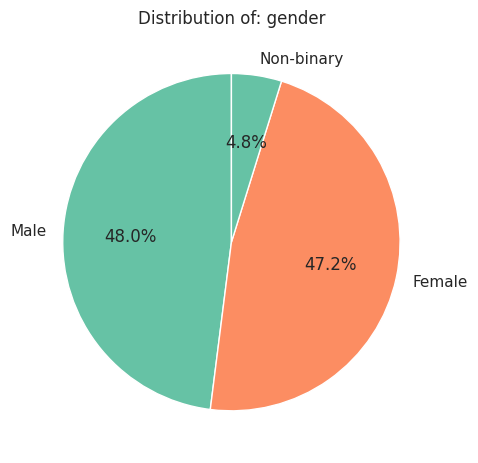

In [7]:
viewDecisionDistribution(df, decision_col='gender')

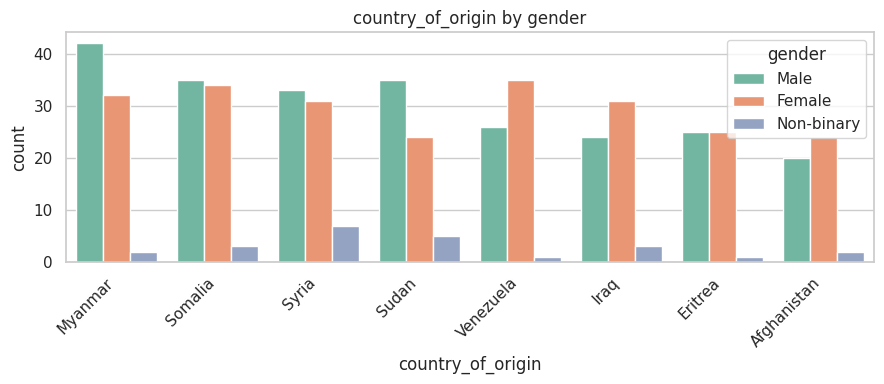

In [8]:
viewCategoricalBreakdown(df, 'country_of_origin', hue_col='gender')

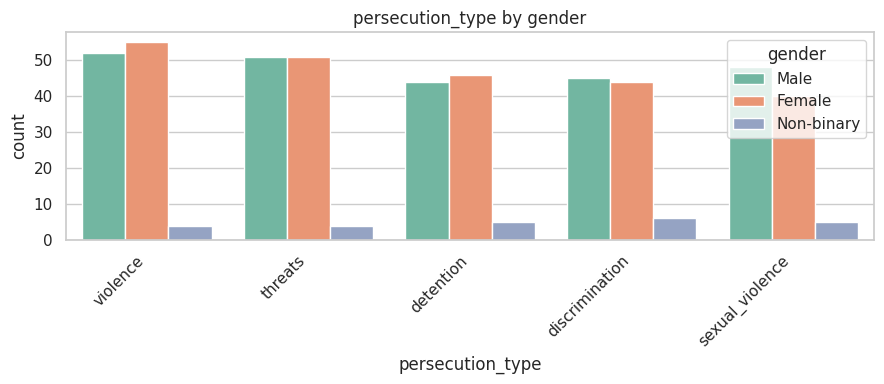

In [6]:
viewCategoricalBreakdown(df, 'persecution_type', hue_col='gender')

## 3. The Credibility Score

The AI converts each applicant's information into two numeric scores before making a decision: a **credibility score** and a **risk score**.   Let's look at credibility first.

Credibility is supposed to represent how believable the applicant's claim is. Look at how it's actually calculated:

```
credibility = base_score + language_effect + education_effect + trauma_penalty
```

Language and education inflate the score. Reported trauma deflates it by ~0.08.

This means the system is rewarding applicants who can express themselves in formal, fluent ways, and penalizing those whose testimony is fragmented or inconsistent. The problem: fragmented, inconsistent testimony is a documented psychological response to trauma, not a sign of lying.

In [ ]:
# Overall credibility distribution
viewScoreDistribution(df, 'credibility_score')

In [ ]:
# Does language proficiency inflate credibility?
viewScoreDistribution(df, 'credibility_score', hue_col='language_proficiency')

In [ ]:
# Does reported trauma deflate credibility?
viewScoreDistribution(df, 'credibility_score', hue_col='reported_trauma')

print("Average credibility score:")
print(df.groupby('reported_trauma')['credibility_score'].mean().round(3))

**Your turn:** Try swapping `'reported_trauma'` for `'education_level'` or `'gender'` in the cell below. What patterns do you find? Are any of them surprising or hard to justify?

In [ ]:
# Change hue_col to explore other variables
viewScoreDistribution(df, 'credibility_score', hue_col='reported_trauma')  # <- change this

## 4. The Risk Score

The risk score represents how dangerous the applicant's situation is in their home country. It's built from three inputs:

```
risk = country_base + persecution_type_effect + gender_effect + noise
```

Unlike credibility, risk is mostly driven by objective factors about the applicant's situation — which country they're from, what type of harm they faced, and their gender. But that doesn't mean it's free of assumptions. **Someone decided** what base risk to assign to each country, and what gender effects to apply.

In [ ]:
# Overall risk score distribution
viewScoreDistribution(df, 'risk_score')

In [ ]:
# Risk score by country of origin
# Who decided these base rates? What are they based on?
viewScoreDistribution(df, 'risk_score', hue_col='country_of_origin')
print("Average risk score by country:")
print(df.groupby('country_of_origin')['risk_score'].mean().sort_values(ascending=False).round(3))

In [ ]:
# Risk score by persecution type
viewScoreDistribution(df, 'risk_score', hue_col='persecution_type')
print("\nAverage risk score by persecution type:")
print(df.groupby('persecution_type')['risk_score'].mean().sort_values(ascending=False).round(3))

**Your turn:** Run the cell below to look at risk score by gender. Female and Non-binary applicants get slightly higher risk scores.

Is this appropriate? You could argue it reflects real patterns of gendered persecution. You could also argue it encodes a stereotype. Discuss with your group.

In [ ]:
viewScoreDistribution(df, 'risk_score', hue_col='gender')
print("Average risk score by gender:")
print(df.groupby('gender')['risk_score'].mean().round(3))

**Compare the two scores:** Credibility and risk are supposed to measure different things. But are they correlated? Run the cell below.

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(df['risk_score'], df['credibility_score'],
            c=df['final_decision'].map({'approve':'#66c2a5','deny':'#fc8d62'}),
            alpha=0.4, edgecolors='none')
plt.xlabel('Risk Score')
plt.ylabel('Credibility Score')
plt.title('Risk vs Credibility (green=approve, red=deny)')
handles = [plt.scatter([],[],c='#66c2a5',label='approve'),
           plt.scatter([],[],c='#fc8d62',label='deny')]
plt.legend(handles=handles)
plt.tight_layout()
plt.show()
print(f"Correlation between risk and credibility: {df['risk_score'].corr(df['credibility_score']):.3f}")

## 5. The AI Decision Rule

The AI combines the two scores using this rule:

```
S = 0.60 * risk_score + 0.40 * credibility_score

approve  if  S > 0.67  AND  credibility_score > 0.50
deny     otherwise
```

In [ ]:
# Overall decision distribution
viewDecisionDistribution(df, decision_col='AI_decision')

In [ ]:
# Approval rates by country — who benefits from this rule?
viewApprovalRateBy(df, 'country_of_origin')

In [ ]:
# Approval rates by gender
viewApprovalRateBy(df, 'gender')

**Your turn:** Change the argument below to explore approval rates by `'persecution_type'` or `'education_level'`. Are there patterns that are hard to justify?

In [ ]:
# Change the argument to explore different breakdowns
viewApprovalRateBy(df, 'persecution_type')  # <- try changing this

### The Credibility Veto in Action
Notice that credibility acts as a veto. Even if S is high (the overall case is strong), the application is denied if credibility falls below 0.50. A high-risk applicant fleeing genuine danger can be denied purely because the system judged them not credible enough.

This reflects a documented pattern in real automated RSD systems: credibility assessments dominate outcomes even when objective risk evidence is strong.

Let's find cases where the risk score was high, meaning the applicant faced genuine danger, but the overall case was still denied. How many of those denials were caused by low credibility specifically?

In [ ]:
# High risk but denied
high_risk_denied = df[(df['risk_score'] > 0.70) & (df['final_decision'] == 'deny')]
print(f"High risk (>0.70) but denied: {len(high_risk_denied)} cases")
print(f"Of those, credibility below 0.50: {(high_risk_denied['credibility_score'] < 0.50).sum()} cases")
print(f"\nTrauma rate among high-risk denied: {high_risk_denied['reported_trauma'].mean():.1%}")
print(f"Trauma rate overall:                {df['reported_trauma'].mean():.1%}")

## 6. Human Oversight — Does It Help?

In theory, human review is the safety net. A human officer can override the AI's decision. In practice, only **~10%** of cases are reviewed.

In [ ]:
print(f"Cases reviewed by human:       {df['human_reviewed'].sum()} ({df['human_reviewed'].mean():.1%})")
print(f"Cases overridden:              {df['human_override'].sum()} ({df['human_override'].mean():.1%})")
print(f"Of reviewed cases, overridden: {df[df['human_reviewed']]['human_override'].mean():.1%}")

In [ ]:
# Did overrides help?
overridden = df[df['human_override'] == True]
print("AI decision vs final decision among overridden cases:")
print(overridden[['AI_decision','final_decision']].value_counts())

In [ ]:
# Processing time: oversight vs efficiency
viewScoreDistribution(df, 'processing_time_days', hue_col='human_reviewed')
print("Average processing time (days):")
print(df.groupby('human_reviewed')['processing_time_days'].mean().round(1))

## 7. Appeals

About 30% of denied applicants appeal. Let's see what happens when they do.

In [ ]:
denied = df[df['final_decision'] == 'deny']
print(f"Cases that appealed: {df['appealed'].sum()} ({denied['appealed'].mean():.1%} of denied cases)")

appeal_counts = df[df['appealed'] == True]['appeal_outcome'].value_counts()
plt.figure(figsize=(5,4))
plt.pie(appeal_counts, labels=appeal_counts.index, autopct='%1.1f%%',
        colors=['#fc8d62','#66c2a5'], startangle=90)
plt.title('Appeal Outcomes')
plt.tight_layout()
plt.show()



**Think about this:** The people most likely to successfully appeal are also probably the most resourced: those who can find legal help, navigate bureaucracy, and wait out a long process. What does that mean for the most vulnerable applicants?

## 8. Write Your Own Bias Audit

In the real world, after an AI system has made thousands of decisions, auditors look back and ask: *did the system treat certain groups unfairly in ways that can't be justified by the strength of their case?*

Unlike the rest of this workbook, there is no pre-written answer here. A bias audit requires you to decide what counts as suspicious — and that is itself a values judgment.

**Before writing any code, discuss with your group:**
- What would a "fair" decision system look like in this context?
- What patterns in the data would make you suspicious that something went wrong?
- Is it enough to look at approval rates, or do you need to look at case characteristics too?

Then write a function that flags cases you consider potentially biased. It should return `'none'`, `'moderate'`, or `'severe'` for each row.

In [ ]:
def my_bias_audit(row):
    """
    Write your own bias flag logic here.

    Some things you might consider flagging:
    - High risk score but denied (applicant faces real danger but was turned away)
    - Trauma reported but credibility below a threshold (trauma penalty in action)
    - Approved applicants with low risk score (is the bar consistent?)
    - Patterns by country or gender

    Return 'none', 'moderate', or 'severe'
    """

    # YOUR CODE HERE
    # Example (replace with your own logic):
    # if row['reported_trauma'] and row['credibility_score'] < 0.5:
    #     return 'moderate'

    return 'none'  # default — replace this

df['my_bias_flag'] = df.apply(my_bias_audit, axis=1)
print("Your bias flag distribution:")
print(df['my_bias_flag'].value_counts())

Now visualize what you flagged. Who are the flagged cases?

In [ ]:
# What does your flagged population look like?
flagged = df[df['my_bias_flag'] != 'none']
print(f"Total flagged: {len(flagged)} ({len(flagged)/len(df):.1%} of all cases)")

if len(flagged) > 0:
    print(f"\nCountry breakdown:")
    print(flagged['country_of_origin'].value_counts())
    print(f"\nGender breakdown:")
    print(flagged['gender'].value_counts())
    print(f"\nFinal decision breakdown:")
    print(flagged['final_decision'].value_counts())
    print(f"\nAvg credibility (flagged): {flagged['credibility_score'].mean():.3f}")
    print(f"Avg credibility (all):     {df['credibility_score'].mean():.3f}")
    print(f"\nAvg risk score (flagged):  {flagged['risk_score'].mean():.3f}")
    print(f"Avg risk score (all):      {df['risk_score'].mean():.3f}")

**Compare with a classmate:** Did you write the same audit function? If not, whose definition of bias is correct? What does it mean that two people looking at the same data can reach different conclusions about what counts as unfair?

## 9. Make the system better!

Let's train a Random Forest to predict `final_decision` and examine which features it relies on most.

In [ ]:
features = df.drop(columns=['id', 'final_decision', 'AI_decision',
                              'human_reviewed', 'human_override',
                              'appealed', 'appeal_outcome', 'my_bias_flag'])
targets = (df['final_decision'] == 'approve').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    features, targets, test_size=0.3, random_state=42)
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum  = pd.get_dummies(X_test, drop_first=True).reindex(
    columns=X_train_dum.columns, fill_value=0)

baseline_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
baseline_model.fit(X_train_dum, y_train)
y_pred = baseline_model.predict(X_test_dum)
print(f"Model accuracy: {accuracy_score(y_test, y_pred):.3f}")

In [ ]:
plotFeatureImportance(baseline_model, X_train_dum)

### Drop Features and Retrain

The most important features might be proxies for sensitive attributes. `credibility_score` encodes language and education bias. `country_of_origin` might encode national stereotypes.

**Your turn:** Add features to `featuresToDrop` below and retrain. Does removing biased features reduce accuracy? Does it change the importance chart? Is there a version of the model you'd consider fair enough to use?

In [ ]:
# Add column names here to remove them from training
# e.g. featuresToDrop = ['credibility_score', 'country_of_origin']
featuresToDrop = []

# --- don't modify below this line ---
features_dropped = df.drop(columns=['id', 'final_decision', 'AI_decision',
                                     'human_reviewed', 'human_override',
                                     'appealed', 'appeal_outcome',
                                     'my_bias_flag'] + featuresToDrop)

X_tr, X_te, y_tr, y_te = train_test_split(features_dropped, targets, test_size=0.3, random_state=42)
X_tr_d = pd.get_dummies(X_tr, drop_first=True)
X_te_d = pd.get_dummies(X_te, drop_first=True).reindex(columns=X_tr_d.columns, fill_value=0)

new_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
new_model.fit(X_tr_d, y_tr)
y_pred_new = new_model.predict(X_te_d)

print(f"Accuracy with dropped features: {accuracy_score(y_te, y_pred_new):.3f}")
print(f"Baseline accuracy:              {accuracy_score(y_test, y_pred):.3f}")

plotFeatureImportance(new_model, X_tr_d)

In [ ]:
# Compare approval rates before and after
X_test_copy = X_test.copy()
X_test_copy['baseline'] = baseline_model.predict(X_test_dum)
X_test_copy['new_model'] = new_model.predict(X_te_d)

print("Approval rate by country — baseline model:")
print(X_test_copy.groupby('country_of_origin')['baseline'].mean().round(2))
print("\nApproval rate by country — new model:")
print(X_test_copy.groupby('country_of_origin')['new_model'].mean().round(2))

## 10. Discussion Questions

**1. The Credibility Veto**
The AI requires credibility to clear a threshold independently, regardless of how strong the risk evidence is. We showed that trauma survivors,  especially those fleeing sexual violence or detention, are most penalized by this design. Is there a way to assess credibility that doesn't disadvantage trauma survivors? Or should credibility play a smaller role altogether?

**2. Who Decides the Weights?**
The decision rule assigns 60% weight to risk and 40% to credibility. Someone chose those numbers. What would change if you flipped them? Who should have input into decisions like this, and through what process?

**3. Human Oversight**
Only ~10% of cases get human review. Of those, about half are overridden. Is this meaningful oversight, or is it closer to rubber-stamping? What would a more robust human-in-the-loop system look like — and what would it cost?

**4. The Appeals Gap**
~40% of appeals are overturned, meaning the original decision was wrong. But filing an appeal takes time, resources, and knowledge of the system. Who is least likely to appeal even when they should? What does that mean for the real-world error rate?

**5. Your Bias Audit**
Compare your `my_bias_audit` function with a classmate's. Did you flag different cases? Which definition of bias do you think is more defensible, and why? Is there a single correct answer?

**6. Should This System Exist?**
Given everything you have seen, do you think an AI system should be used to make or assist refugee status decisions? If yes, what safeguards would you require? If no, what should replace it?